In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
fold1_X_train = pd.read_csv('data/processed/fold_1_X_train.csv')
fold1_X_test = pd.read_csv('data/processed/fold_1_X_test.csv')  
fold1_y_train = pd.read_csv('data/processed/fold_1_y_train.csv')
fold1_y_test = pd.read_csv('data/processed/fold_1_y_test.csv')
fold2_X_train = pd.read_csv('data/processed/fold_2_X_train.csv')
fold2_X_test = pd.read_csv('data/processed/fold_2_X_test.csv')  
fold2_y_train = pd.read_csv('data/processed/fold_2_y_train.csv')
fold2_y_test = pd.read_csv('data/processed/fold_2_y_test.csv')

print("Ready for Feature Classification:")
print(f"  Training features: {fold1_X_train.shape}")
print(f"  Features to classify: {len(fold1_X_train.columns)}")
print(f"  Data integrity verified: ✅")

Ready for Feature Classification:
  Training features: (8495, 18)
  Features to classify: 18
  Data integrity verified: ✅


In [11]:
fold1_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495 entries, 0 to 8494
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num__temp_C         8495 non-null   float64
 1   num__dewpoint_C     8495 non-null   float64
 2   num__slp_hPa        8495 non-null   float64
 3   num__wind_dir_deg   8495 non-null   float64
 4   num__precip_mm      8495 non-null   float64
 5   cat__sky_cover_0    8495 non-null   float64
 6   cat__sky_cover_0 -  8495 non-null   float64
 7   cat__sky_cover_1    8495 non-null   float64
 8   cat__sky_cover_1 -  8495 non-null   float64
 9   cat__sky_cover_5    8495 non-null   float64
 10  cat__sky_cover_5 -  8495 non-null   float64
 11  cat__sky_cover_6    8495 non-null   float64
 12  cat__sky_cover_6 -  8495 non-null   float64
 13  cat__sky_cover_7 -  8495 non-null   float64
 14  dt__dt__hour        8495 non-null   float64
 15  dt__dt__dow         8495 non-null   float64
 16  dt__dt

In [13]:
fold1_X_train.describe()

,num__temp_C,num__dewpoint_C,num__slp_hPa,num__wind_dir_deg,num__precip_mm,cat__sky_cover_0,cat__sky_cover_0 -,cat__sky_cover_1,cat__sky_cover_1 -,cat__sky_cover_5,cat__sky_cover_5 -,cat__sky_cover_6,cat__sky_cover_6 -,cat__sky_cover_7 -,dt__dt__hour,dt__dt__dow,dt__dt__month,dt__dt__is_weekend
count,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000
mean,8.029677e-17,4.182123e-17,2.970980e-15,-7.360537e-17,-1.200269e-16,0.780224,0.172808,0.007416,0.005297,0.018599,0.006710,0.005180,0.003649,0.000118,11.329017,3.007652,7.359859,0.289229
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,0.414119,0.378103,0.085802,0.072593,0.135113,0.081643,0.071786,0.060302,0.010850,7.023619,2.002015,3.274055,0.453431
min,-3.002637e+00,-3.394120e+00,-2.868419e+00,-1.846816e+00,-2.820836e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,-8.337260e-01,-7.368357e-01,-6.852662e-01,-9.813172e-01,-5.532014e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,5.000000,0.000000
50%,-9.539888e-03,-2.088343e-02,-1.261662e-01,3.650139e-01,3.538525e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,8.000000,0.000000
75%,7.604234e-01,8.327520e-01,7.257959e-01,8.458464e-01,8.073794e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,10.000000,1.000000
max,2.571464e+00,2.347266e+00,3.028756e+00,1.519012e+00,1.260906e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,6.000000,12.000000,1.000000


In [17]:
def plot_numeric_distribution(df, column, label=None, bins=30):
    """
    Plot histogram + boxplot for a numeric feature.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the feature.
    column : str
        Column name to plot.
    label : str, optional
        Pretty label for titles/axes (defaults to column name).
    bins : int
        Number of bins for histogram.
    """
    if label is None:
        label = column

    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(f"Distribution of {label}")
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {label}")
    plt.xlabel(label)
    plt.show()

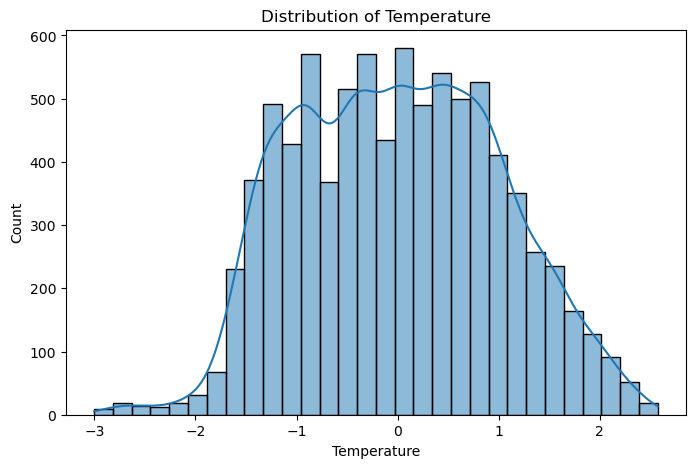

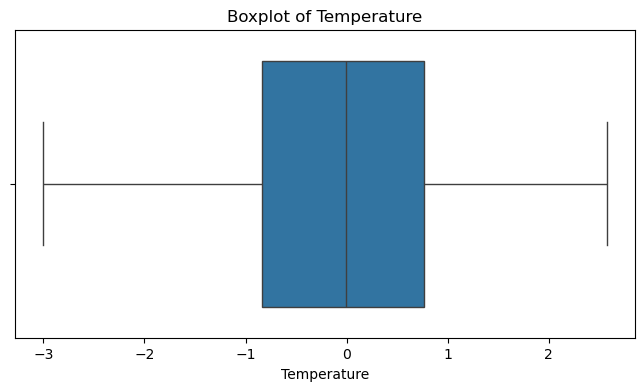

In [18]:
plot_numeric_distribution(fold1_X_train, "num__temp_C", label="Temperature")

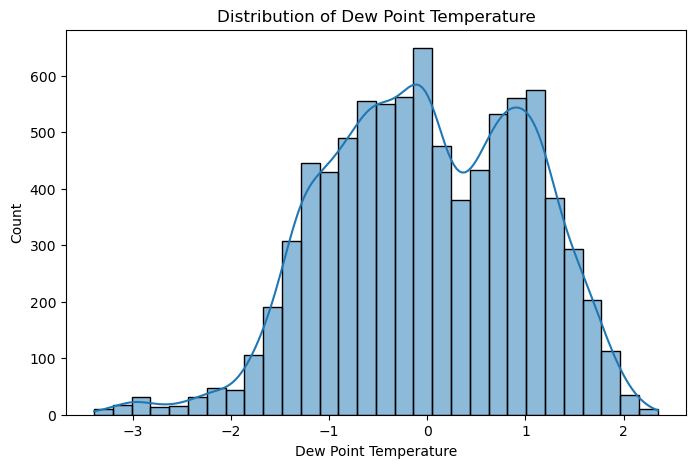

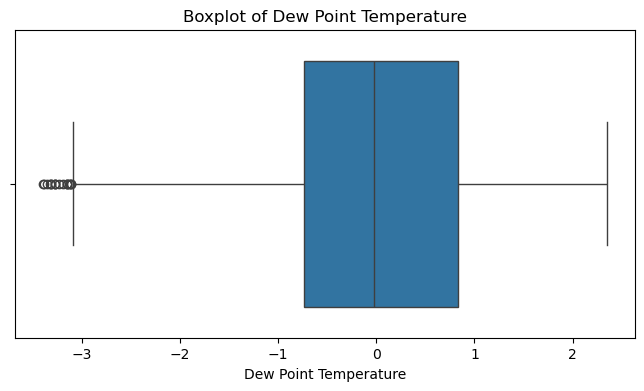

In [19]:
plot_numeric_distribution(fold1_X_train, "num__dewpoint_C", label="Dew Point Temperature")

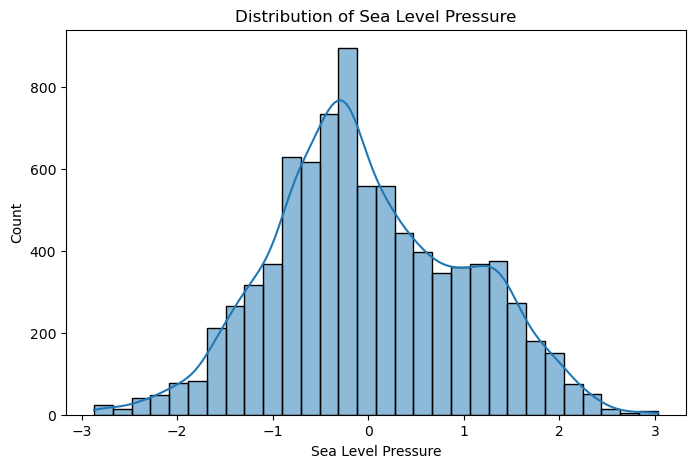

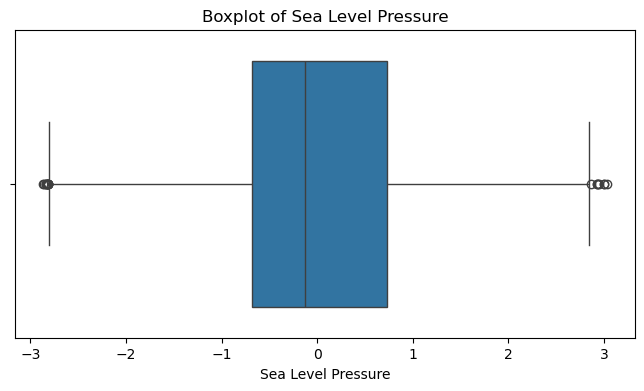

In [20]:
plot_numeric_distribution(fold1_X_train, "num__slp_hPa", label="Sea Level Pressure")

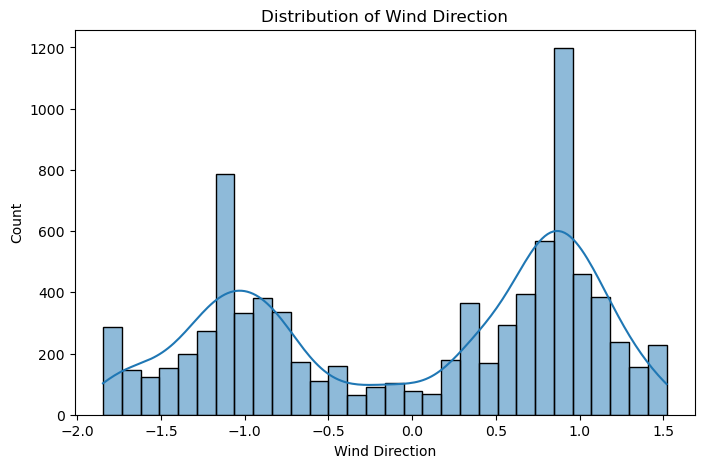

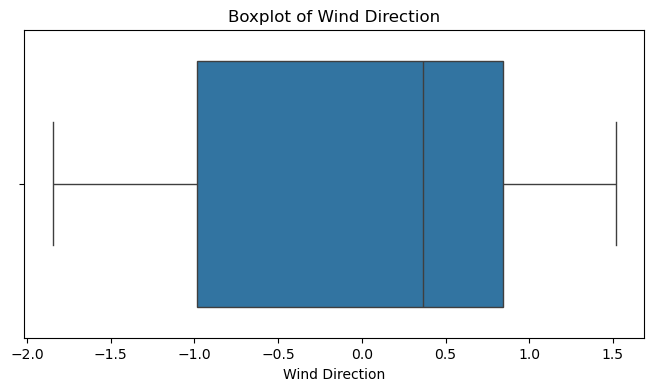

In [21]:
plot_numeric_distribution(fold1_X_train, "num__wind_dir_deg", label="Wind Direction")

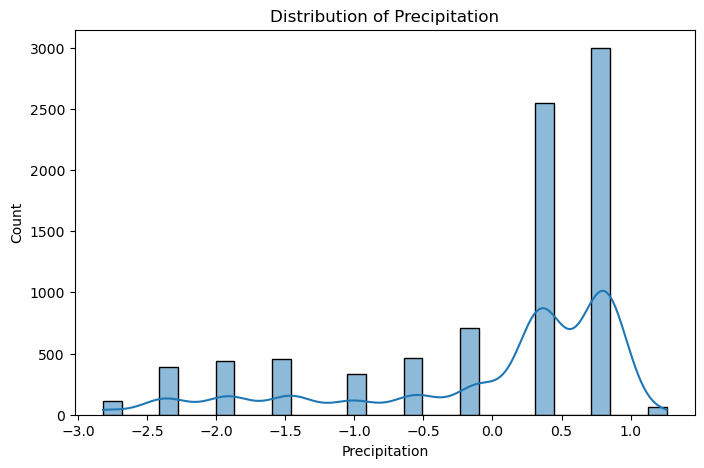

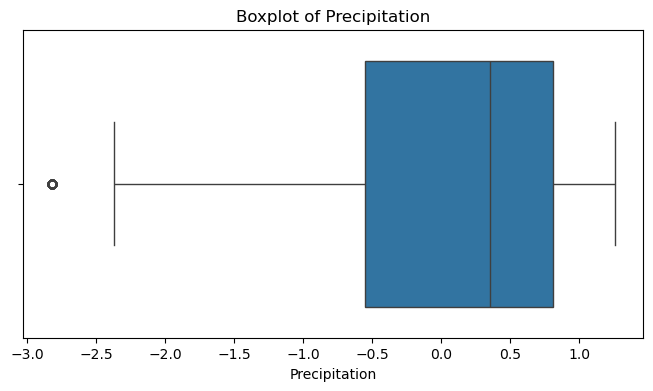

In [22]:
plot_numeric_distribution(fold1_X_train, "num__precip_mm", label="Precipitation")

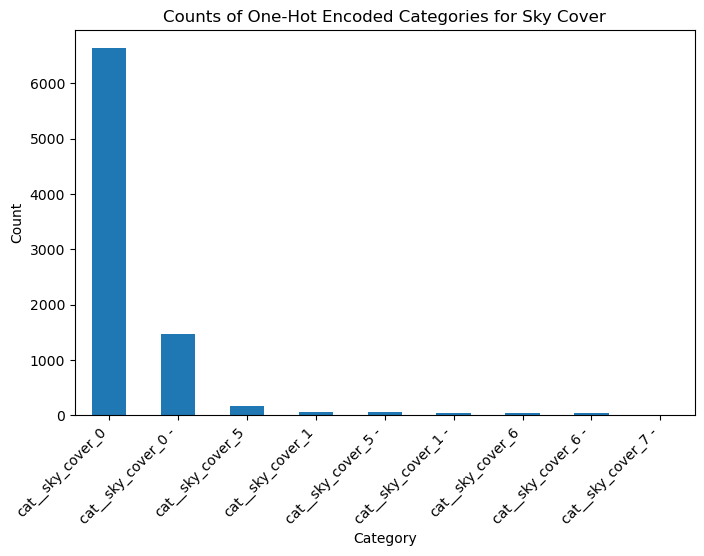

In [23]:
ohe_cols = [col for col in fold1_X_train.columns if col.startswith("cat__sky_cover_")]

# Sum across rows to get counts per category
counts = fold1_X_train[ohe_cols].sum().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(8,5))
counts.plot(kind="bar")
plt.title("Counts of One-Hot Encoded Categories for Sky Cover")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

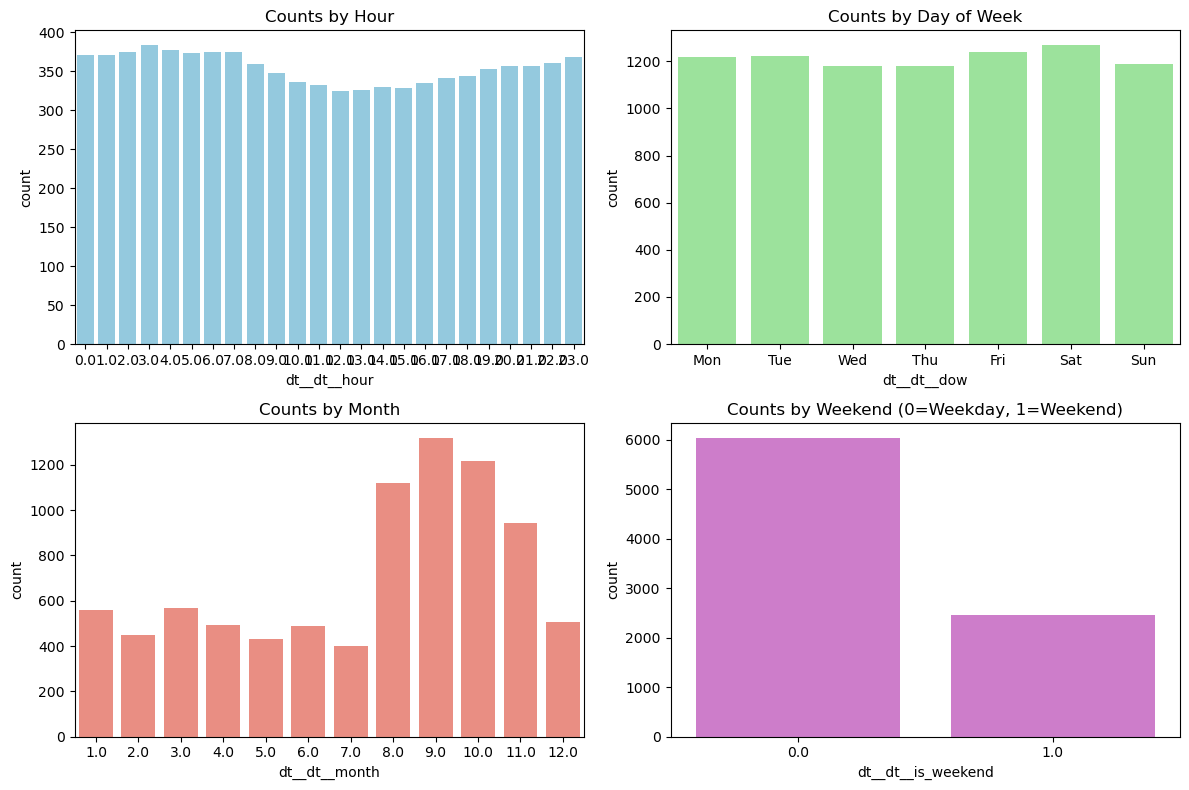

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x="dt__dt__hour", data=fold1_X_train, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Counts by Hour")
sns.countplot(x="dt__dt__dow", data=fold1_X_train, ax=axes[0,1], color="lightgreen")
axes[0,1].set_title("Counts by Day of Week")
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
sns.countplot(x="dt__dt__month", data=fold1_X_train, ax=axes[1,0], color="salmon")
axes[1,0].set_title("Counts by Month")
sns.countplot(x="dt__dt__is_weekend", data=fold1_X_train, ax=axes[1,1], color="orchid")
axes[1,1].set_title("Counts by Weekend (0=Weekday, 1=Weekend)")
plt.tight_layout()
plt.show()